In [122]:
!pip3 install gymnasium[classic_control]

# Environment Setup

Goal: Use DQN model to setup optimal temperature for a room <br>

Factors affecting initial temperature: <br>
<ol>
    <li> Room booking status </li>
    <li> Outside Temp</li>
    <li> Day </li>
    <li> Time </li>
</ol>

Action taken by DQN: <br>
<ol>
    <li> Increase Temperature </li>
    <li> Decrease Temperature   </li>
    <li> Maintain Temperature </li>
</ol>

Rewards for DQN : <br>
<ol>
    <li> Energy Consumption Levels</li>
    <li> User Comfort</li>

In [123]:
import gymnasium as gym # OpenAI env
import math
import random
import matplotlib # Plot
import matplotlib.pyplot as plt
from collections import namedtuple, deque # Python build-in data structure
from itertools import count

In [124]:
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [125]:
# Machine Learning to predict energy consumption

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
training_data = pd.read_excel('output.xlsx')
# for day data change mon to 1, tue to 2 etc

training_data['day_'] = training_data['day_'].replace(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],[1,2,3,4,5,6,7])
features = ['day_', 'time_', 'outside_temp', 'inside_temp', 'booking_status']
X = training_data[features]
y = training_data['energy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random forest model to predict energy consumption

rf_model = RandomForestRegressor(n_estimators=200, random_state= 50) # 200 trees, random_state for reproducibility
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# percentage error
percentage_error = (np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
print(f"Percentage Error: {percentage_error}")

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Mean Squared Error: 493.95322464669016
Percentage Error: 0.5093511249286076


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [126]:
# Equation to calculate energy consumption
def energy_consumption(day, time, outside_temp, inside_temp, booking_status, change_in_temp):
    day = day
    time = time
    outside_temp = outside_temp
    inside_temp = inside_temp
    booking_status = booking_status
    change_in_temp = change_in_temp
    energy_consumption = rf_model.predict([[day, time, outside_temp, inside_temp, booking_status]])
    return energy_consumption



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
import gym
import numpy as np
from gym import spaces

class ThermostatEnvironment(gym.Env):
    def __init__(self):
        super(ThermostatEnvironment, self).__init__()
        self.day = 1
        self.time = 1
        self.booking_status = 0
        self.outside_temp = 30
        self.inside_temp = 18  # Desired room temperature
        self.action_space = spaces.Discrete(3)  # Increase, Decrease, Maintain
        self.observation_space = spaces.Box(low=np.array([1, 1, 0, 23, 18]), high=np.array([5, 24, 1, 40, 25]), dtype=np.float32)
        self.temperature = 18  # Current room temperature
        self.max_temp = 25
        self.min_temp = 18
        self.reward = 0
        self.done = False

    def step(self, action):
        # Action logic
        if action == 0:  # Decrease temperature (too hot)
            self.temperature -= 1
        elif action == 2:  # Increase temperature (too cold)
            self.temperature += 1
        else:  # Maintain temperature
            pass

        # Ensure temperature is within bounds
        self.temperature = np.clip(self.temperature, self.min_temp, self.max_temp)

        # Calculate energy consumption
        energy = energy_consumption(self.day, self.time, self.outside_temp, self.inside_temp, self.booking_status, self.temperature - self.inside_temp)

        # Calculate reward
        # Adjust the energy_reward calculation
        energy_reward = -((energy - 3200) / 3200)**2  # Quadratic penalty for deviation

        # Introduce a threshold for acceptable energy consumption
        acceptable_energy_threshold = 3200  # Adjust based on your criteria
        if energy <= acceptable_energy_threshold:
            energy_reward += 0.2
        print(f"Energy Reward: {energy_reward}")

        # Modify the comfort_reward calculation
        temperature_range_penalty = 0.1  # Adjust based on your criteria
        comfort_reward = -abs(self.temperature - self.inside_temp) - temperature_range_penalty * abs(self.temperature - 20)

        print(f"Comfort Reward: {comfort_reward}")

        # Adjust the weights and introduce a trade-off factor
        trade_off_factor = 0.5  # Adjust based on your desired trade-off
        reward = (1 - trade_off_factor) * energy_reward + trade_off_factor * comfort_reward
        print(f"Total Reward: {reward}")

        self.reward += reward
        self.done = True

        return np.array([self.day, self.time, self.booking_status, self.outside_temp, self.inside_temp]), reward, self.done, {}

    def reset(self):
        self.day = 1
        self.time = 1
        self.booking_status = 0
        self.outside_temp = 30
        self.inside_temp = 18
        self.temperature = 18
        self.reward = 0
        self.done = False
        return np.array([self.day, self.time, self.booking_status, self.outside_temp, self.inside_temp])

    def render(self):
        pass


# Q Network

In [128]:
# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import copy

class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 25)  # 5 input features, 1 output features
        self.fc2 = nn.Linear(25,25)
        self.fc3 = nn.Linear(25, action_size) # 10 input features, 2 output features

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [129]:
# memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, next_state, reward))
        else:
            self.memory.pop(0)
            self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Training

In [130]:
# Train the model

# Hyperparameters
learning_rate = 0.001
gamma = 0.9
buffer_limit = 50000
batch_size = 32
tau = 0.01
input_size = 5
action_size = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the environment
env = ThermostatEnvironment()
env.reset()

# Initialize the model
model = DQN(input_size, action_size).to(device)
target_model = copy.deepcopy(model)
target_model.load_state_dict(model.state_dict())
target_model.eval()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the replay buffer
replay_buffer = []
replay_buffer_size = 0

# Initialize the training parameters
if torch.cuda.is_available():
    print('Using GPU')
    num_episodes = 500
else:
    print('Using CPU')
    num_episodes = 100
epsilon = 0.1
epsilon_decay = 0.99
epsilon_min = 0.01
update_every = 10
update_count = 0
loss_fn = nn.MSELoss()


# Get number of actions from gym action space
n_actions = env.action_space.n

# Get number of states from gym observation space
state,info = env.reset(),{}
n_states = len(state)

policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
memory = ReplayMemory(10000)

def select_action(state, epsilon):
    global steps_done
    sample = random.random()
    eps_threshold = epsilon
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episodes_duration = []

def optimize_model():
    if len(memory) < batch_size:
        return None

    # Sample a batch from the replay memory
    batch = memory.sample(batch_size)

    # Unpack the batch
    state_batch, action_batch, next_state_batch, reward_batch = map(torch.cat, zip(*batch))
    action_batch = action_batch.view(-1, 1).long()

    # Compute Q-values for the current state-action pairs
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute Q-values for the next state and find the maximum
    next_state_values = target_net(next_state_batch).max(1)[0].detach()

    # Compute the expected Q-values using the Bellman equation
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Calculate the Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss





Using CPU


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 0, Total Reward: -0.5789048075675964, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 1, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 2, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 3, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 4, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 5, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 6, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 17, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 18, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 19, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 20, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 21, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 22, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 23, Total Reward: -0.1289048045873642, Loss: None
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total

<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Rando

Episode 43, Total Reward: -0.1289048045873642, Loss: 0.1490778923034668
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 44, Total Reward: -0.1289048045873642, Loss: 0.11102715134620667
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 45, Total Reward: -0.1289048045873642, Loss: 0.03897826746106148
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 46, Total Reward: -0.1289048045873642, Loss: 0.03512951731681824
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 47, Total Reward: -0.1289048045873642, Loss: 0.08142238855361938
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 48, Total Reward: -0.1289048045873642, Loss: 0.0795888602733612
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 49, Total Reward: -0.5789048075675964, Loss: 0.0709279477596283
Energy Reward: [-0.05780961]
C

<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Rando

Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 55, Total Reward: -0.1289048045873642, Loss: 0.03221842274069786
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 56, Total Reward: -0.1289048045873642, Loss: 0.03110678493976593
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 57, Total Reward: -0.1289048045873642, Loss: 0.022378159686923027
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 58, Total Reward: -0.5789048075675964, Loss: 0.021566975861787796
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 59, Total Reward: -0.5789048075675964, Loss: 0.027604326605796814
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 60, Total Reward: -0.5789048075675964, Loss: 0.032878365367650986
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 61, Total R

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(

Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 67, Total Reward: -0.1289048045873642, Loss: 0.01780981570482254
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 68, Total Reward: -0.1289048045873642, Loss: 0.017777450382709503
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 69, Total Reward: -0.5789048075675964, Loss: 0.025562243536114693
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 70, Total Reward: -0.5789048075675964, Loss: 0.022056160494685173
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 71, Total Reward: -0.5789048075675964, Loss: 0.03485846519470215
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 72, Total Reward: -0.1289048045873642, Loss: 0.042163632810115814
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 73, Total R

<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Rando

Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 79, Total Reward: -0.5789048075675964, Loss: 0.023078972473740578
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 80, Total Reward: -0.5789048075675964, Loss: 0.024694576859474182
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 81, Total Reward: -0.5789048075675964, Loss: 0.028834640979766846
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 82, Total Reward: -0.5789048075675964, Loss: 0.029631607234477997
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 83, Total Reward: -0.1289048045873642, Loss: 0.022707656025886536
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 84, Total Reward: -0.1289048045873642, Loss: 0.02301567606627941
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 85, Total 

<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Rando

Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 91, Total Reward: -0.5789048075675964, Loss: 0.024888750165700912
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 92, Total Reward: -0.5789048075675964, Loss: 0.01808856427669525
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 93, Total Reward: -0.1289048045873642, Loss: 0.022102326154708862
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 94, Total Reward: -0.1289048045873642, Loss: 0.021254833787679672
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 95, Total Reward: -0.1289048045873642, Loss: 0.02721811644732952
Energy Reward: [-0.05780961]
Comfort Reward: -0.2
Total Reward: [-0.1289048]
Episode 96, Total Reward: -0.1289048045873642, Loss: 0.024255692958831787
Energy Reward: [-0.05780961]
Comfort Reward: -1.1
Total Reward: [-0.5789048]
Episode 97, Total R

<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
<ipython-input-130-01ba37964ec3>:90: UserWarning: Using a target size (torch.Size([32, 1, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Rando

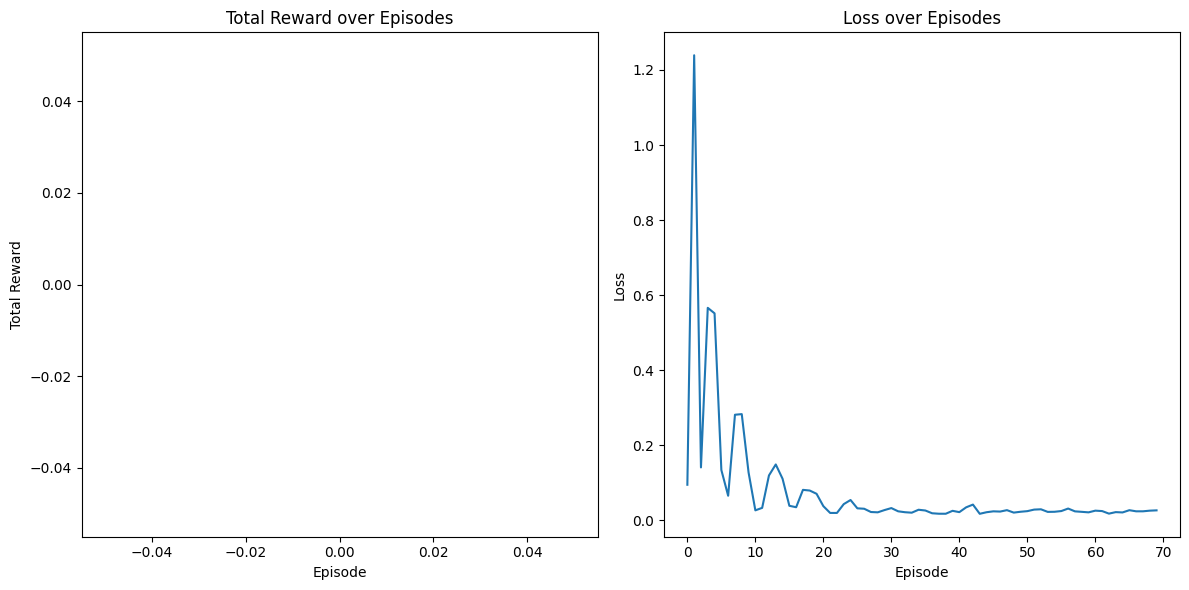

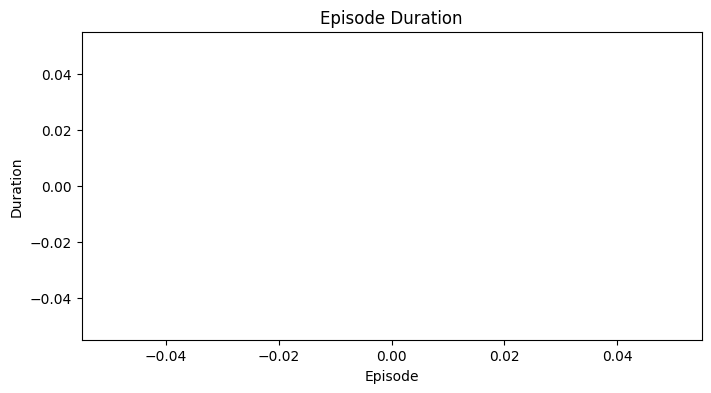

In [132]:
# Training loop

import matplotlib.pyplot as plt

episode_rewards = []
episode_losses = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor([next_state], device=device, dtype=torch.float32)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        memory.push(state, action, next_state, reward)
        state = next_state
        total_reward += reward.item()
        loss = optimize_model()
        steps += 1

    # Check if loss is not None before accessing 'item'
    if loss is not None:
        episode_losses.append(loss.item())

    print(f"Episode {episode}, Total Reward: {total_reward}, Loss: {loss}")

    if episode % update_every == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot total rewards and losses
plt.figure(figsize=(12, 6))

# Plot the total rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward over Episodes')

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')

plt.tight_layout()
plt.show()

# Plot the duration of each episode
plt.figure(figsize=(8, 4))
plt.plot(episodes_duration)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Episode Duration')
plt.show()
